# Assignment 4

Before working on this assignment please read these instructions fully. In the submission area, you will notice that you can click the link to **Preview the Grading** for each step of the assignment. This is the criteria that will be used for peer grading. Please familiarize yourself with the criteria before beginning the assignment.

This assignment requires that you to find **at least** two datasets on the web which are related, and that you visualize these datasets to answer a question with the broad topic of **religious events or traditions** (see below) for the region of **Burbank, California, United States**, or **United States** more broadly.

You can merge these datasets with data from different regions if you like! For instance, you might want to compare **Burbank, California, United States** to Ann Arbor, USA. In that case at least one source file must be about **Burbank, California, United States**.

You are welcome to choose datasets at your discretion, but keep in mind **they will be shared with your peers**, so choose appropriate datasets. Sensitive, confidential, illicit, and proprietary materials are not good choices for datasets for this assignment. You are welcome to upload datasets of your own as well, and link to them using a third party repository such as github, bitbucket, pastebin, etc. Please be aware of the Coursera terms of service with respect to intellectual property.

Also, you are welcome to preserve data in its original language, but for the purposes of grading you should provide english translations. You are welcome to provide multiple visuals in different languages if you would like!

As this assignment is for the whole course, you must incorporate principles discussed in the first week, such as having as high data-ink ratio (Tufte) and aligning with Cairo’s principles of truth, beauty, function, and insight.

Here are the assignment instructions:

 * State the region and the domain category that your data sets are about (e.g., **Burbank, California, United States** and **religious events or traditions**).
 * You must state a question about the domain category and region that you identified as being interesting.
 * You must provide at least two links to available datasets. These could be links to files such as CSV or Excel files, or links to websites which might have data in tabular form, such as Wikipedia pages.
 * You must upload an image which addresses the research question you stated. In addition to addressing the question, this visual should follow Cairo's principles of truthfulness, functionality, beauty, and insightfulness.
 * You must contribute a short (1-2 paragraph) written justification of how your visualization addresses your stated research question.

What do we mean by **religious events or traditions**?  For this category you might consider calendar events, demographic data about religion in the region and neighboring regions, participation in religious events, or how religious events relate to political events, social movements, or historical events.

## Tips
* Wikipedia is an excellent source of data, and I strongly encourage you to explore it for new data sources.
* Many governments run open data initiatives at the city, region, and country levels, and these are wonderful resources for localized data sources.
* Several international agencies, such as the [United Nations](http://data.un.org/), the [World Bank](http://data.worldbank.org/), the [Global Open Data Index](http://index.okfn.org/place/) are other great places to look for data.
* This assignment requires you to convert and clean datafiles. Check out the discussion forums for tips on how to do this from various sources, and share your successes with your fellow students!

## Example
Looking for an example? Here's what our course assistant put together for the **Ann Arbor, MI, USA** area using **sports and athletics** as the topic. [Example Solution File](./readonly/Assignment4_example.pdf)

# Solution

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%matplotlib notebook

## Data

### ARDA

from: http://www.thearda.com/Archive/Files/Descriptions/NES16.asp

The data were downloaded from the Association of Religion Data Archives, www.TheARDA.com, and were collected by: Vincent Hutchings, the University of Michigan; Ted Brader, the University of Michigan; Shanto Iyengar, Stanford University; Gary Segura, Stanford University; Simon Jackman, Stanford University

### Pew

"America’s Changing Religious Landscape." Pew Research Center, Washington, D.C. (May 12, 2015) http://www.pewforum.org/2015/05/12/americas-changing-religious-landscape/.

 

In [3]:
# some constants

# The code for the repsondant ID
identity_code = 'V160001'


# BEGIN

I will create a `finaldf` at the beginning and append columns as needed, to maintain a singular view of the data

## ARDA Data: 2016

### Filter out relevant questions

This is a map from the question code which maps the column to the question text, and other info about the question

In [4]:
class Question:
    """Class for storing information about each question, question text, meaning of answers, etc."""
    def __init__(self, code):
        self.code = code.strip()
        self.answers = {}
    
    def __str__(self):
        return "{}: {} answers, question = {}"\
            .format(self.code, len(self.answers), self.text)
    
    def __repr__(self):
        return self.__str__()
    
    def set_text(self, text):
        self.text = text
        
    def add_answer(self, code, val):
        self.answers[int(code)] = val
        
    def string_with_answers(self):
        return '\n'.join([str(self.text), '\n'.join(['{}: {}'.format(q, a) for q,a in self.answers.items()])])
        

### Read question file

In [5]:
questions = {}
with open('a4_project_data/ARDA_2016questions.txt') as f:
    include, readnext = False, 0
    for lin in f:
        lin = lin.strip()
        
        if include:
            if readnext == 4:
                ques.set_text(lin)
            elif readnext == 0:
                try:
                    # split answer code from description
                    code, rest = lin.split(')', 1)
                    # take all tokens but last two (count and percentage)
                    ans = rest.strip().split()[:-2]
                    ques.add_answer(code, ' '.join(ans))
                except ValueError:
                    # hit an empty line after reading answers
                    # print(lin)
                    include = False
                
        if (lin.startswith('*')):
            code = lin[lin.index(')') + 2:]
            ques = Question(code)
            questions[code] = ques
            include = True
            readnext = 5
            
        if readnext > 0:
            readnext -= 1
            
# questions['V162342']
# help(str.split)

#### Questions related to religion

In [6]:
# questions related to religion
religionqs = tuple(filter(lambda c: 'religi' in questions[c].text.lower(), questions.keys()))
rq2 = list(questions.keys())
rq2 = rq2[rq2.index(religionqs[0]):rq2.index(religionqs[-1])]
religionqs = rq2

#### Helper functions to map question codes to questions and answers

In [7]:
filtq = lambda q: (lambda n: questions[q].answers[n] if n > 0 else None)
def map_answers(frame=None, question=None, column=None):
    if frame is not None and question is not None:
        return frame[question].apply(filtq(question))
    elif column is not None:
        return column.apply(filtq(column.name))

### Read survey file, filter all but relevant questions

In [8]:
df0 = pd.read_csv('a4_project_data/ARDA_2016survey.csv')

#### Filter out questions in the question file not found in the data

In [9]:
fnd, nf = [identity_code],0
for k, q in questions.items():
    try:
        df0[k]
        fnd.append(k)
    except KeyError:
        nf += 1
        print('question not found in file:', q)
        
# Filter to only relevant questions
df1 = df0[fnd].rename(columns={identity_code: 'Participant'}).set_index('Participant')
finaldf = pd.DataFrame(index=df1.index)

question not found in file: V162342: 11 answers, question = Please mark how well the following pair of words describes you, even if one word describes you better than the other. 'Conventional, uncreative' describes me...


## Pew Data: 2016

Note: 1 = Yes, 2 = No

In [10]:
cols = pd.read_csv('a4_project_data/Pew_religion_2014.csv', nrows=0).columns
cols.get_loc('qe1')
cols[48:53]
pewraw = pd.read_csv('a4_project_data/Pew_religion_2014.csv', usecols=[0,48,49,50,51], na_values=[' '])

In [11]:
religmap = {1  :"Protestant",
2  :"Catholic",
3  :"Christian",
4  :"Christian",
5  :"Religious Non-Christian",
6  :"Religious Non-Christian",
7  :"Religious Non-Christian",
8  :"Religious Non-Christian",
9  :"Non-religious",
10 :"Non-religious",
11 :"Something else",
12 :"Non-religious",
13 :"Christian",
14 :"Religious Non-Christian",
15 :"Christian",
99 :"Don't Know/Refused"}
pew = pewraw.set_index('resp')['qe1'].apply(lambda d: religmap[d] if d in religmap else None)\
         .reset_index().groupby('qe1').count()['resp'] / pewraw.shape[0]

pew

qe1
Catholic                   0.205184
Christian                  0.052579
Don't Know/Refused         0.000086
Non-religious              0.215449
Protestant                 0.451712
Religious Non-Christian    0.048815
Name: resp, dtype: float64

## Task 1: Identify the participant's religion using questions `V161247A, V161247B, V161248`

### Input: `df1`
### Output: `df2`, columns `Religion_Specific` and `Religion_General`

#### Classify religions from answers about church attendance

In [12]:
dfrlgngen = pd.concat([map_answers(df1, 'V161247A'), map_answers(df1, 'V161247B').dropna()]).dropna()
dfrlgnspec = dfrlgngen[~dfrlgngen.isin(['Protestant', 'Other'])].copy()


dfrlgnspec_prot = df1['V161248'].apply(lambda n: questions['V161248'].answers[n] if n > 0 else None).dropna()
remap = {'Unitarian/Universalist':'Religious Non-Christian', 'Muslim/Islam':'Religious Non-Christian',
         'Latter-day Saints':'Christian', 'Orthodox (SPECIFY)':'Christian','Buddhist':'Religious Non-Christian',
         'Hindu':'Religious Non-Christian', 'Jewish':'Religious Non-Christian', 'Mormon':'Christian',
         'Jehovah\'s Witnesses':'Christian'}
dfother = dfrlgnspec_prot.apply(
    lambda n: n if n in ('Buddhist', 'Hindu', 'Muslim/Islam', 'Native American', 'Mormon', 'Latter-day Saints',
                         'Unitarian/Universalist', 'Jehovah\'s Witnesses', 'Orthodox (SPECIFY)')
                else 'Protestant'
)
dfrlgngen.update(dfother[dfrlgngen == 'Other'])
dfrlgngen = dfrlgngen.apply(lambda n: remap[n] if n in remap else n)

#### Classify non-religious people

Question `V161244` is whether they attend services. `V161246` is, among those, whether they consider themselves part of a religion. `V161241` is whether it is important to them.

In [13]:
nonregi = df1[(df1['V161244'] == 2) & (df1['V161246'] == 2) & (df1['V161241'] == 2)].index
nonreg = pd.Series('Non-religious', index=nonregi)

#### Combine filtered religions to single series

In [14]:
rlgn_spec = pd.concat((dfrlgnspec, dfrlgnspec_prot, nonreg))
rlgn_general = pd.concat((dfrlgngen, nonreg))

In [15]:
finaldf['Religion_Specific'] = rlgn_spec
finaldf['Religion_General'] = rlgn_general
df2 = pd.concat([df1, finaldf], axis=1)

In [16]:
ardadist = rlgn_general.groupby(rlgn_general).count().sort_values() / rlgn_general.shape[0]

## Task 2: Identify preference for candidate

### Input: `df2`
### Output: `df3`, columns `Candidate`, `Preference`

In [17]:
df3 = df2.copy()
df3['V162034A'] = map_answers(df3, 'V162034A')
df3['V162035'] = map_answers(df3, 'V162035')

candpref = df3[['V162034A', 'V162035']].dropna()\
              .rename(columns={'V162034A': 'Candidate', 'V162035': 'Preference'})
finaldf[['Preference', 'Candidate']] = candpref[['Preference', 'Candidate']]

# Filter
# candpref = candpref[~candpref['Candidate'].str.startswith('Other')]
candpref = candpref[candpref['Candidate'].isin(('Donald Trump', 'Hillary Clinton'))].reset_index()

cpstats = candpref.groupby(['Preference', 'Candidate'])['Participant'].aggregate(len)
# df3
# candpref.head(20)
# finaldf

<IPython.core.display.Javascript object>


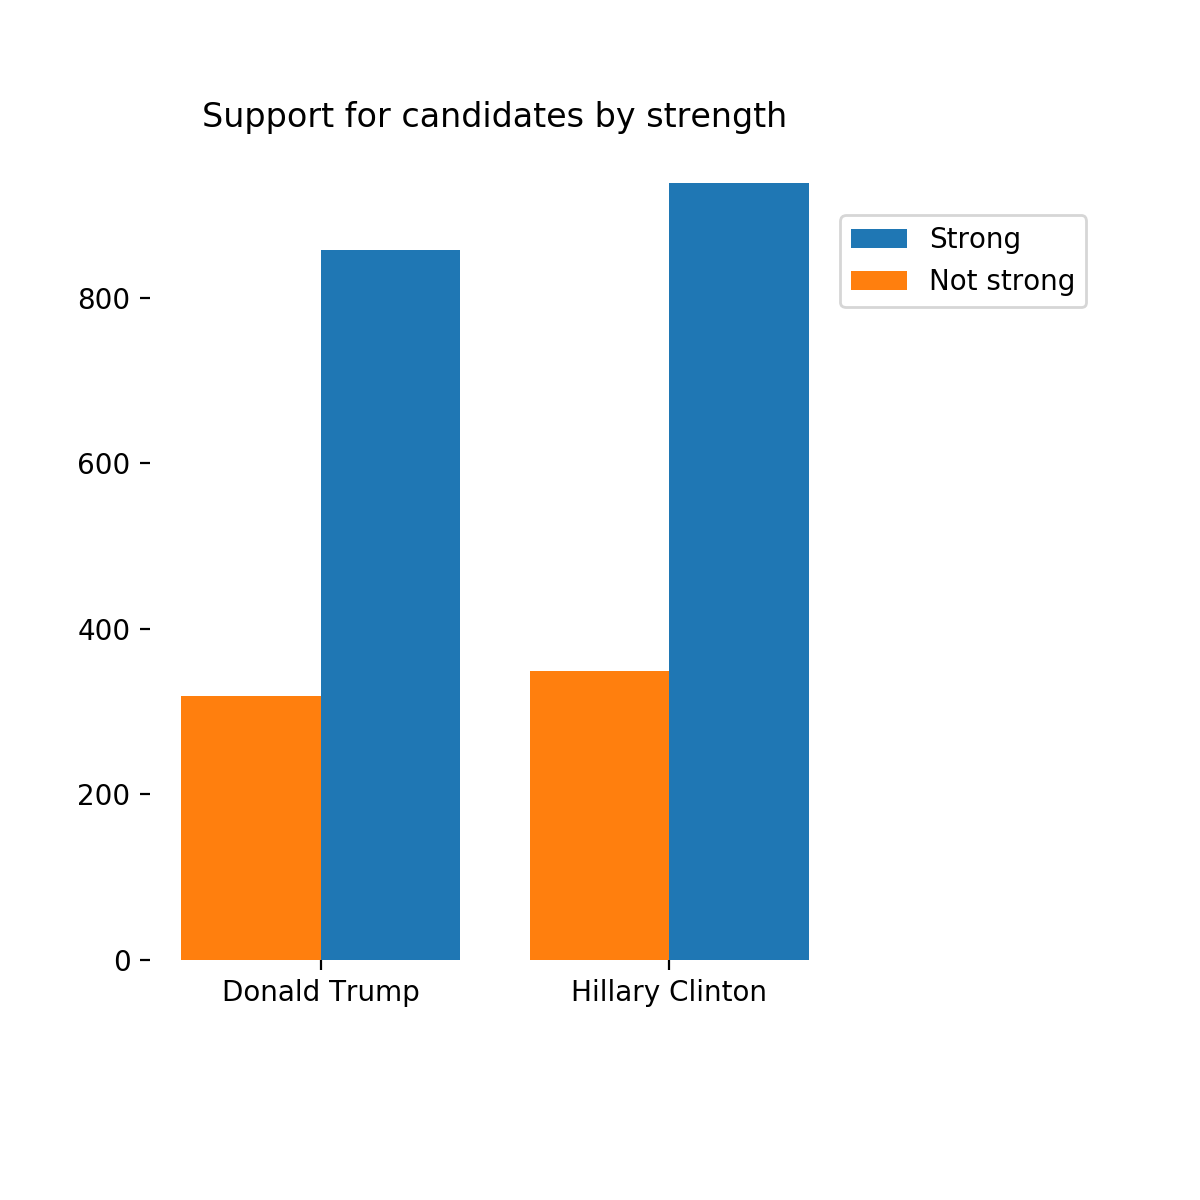

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(6,6))

# ax.tick_params(axis='x', labelrotation=20)
strbars = ax.bar(cpstats.loc['Strong'].index, cpstats.loc['Strong'].values,
                  align='edge', width=0.4)
nstrbars = ax.bar(cpstats.loc['Not strong'].index, cpstats.loc['Not strong'].values,
                   align='edge', width=-0.4)


ax.set_frame_on(False)
ax.set_title('Support for candidates by strength')
ax.legend((strbars, nstrbars), ('Strong', 'Not strong'), loc=(1,0.8))

# ax.set_xmargin(100)
# ax.margins()

plt.subplots_adjust(bottom=0.2, right=0.7)

## Task 3: Assess strength of religion belief

### Input: `df3`
### Output: `df4`, columns `Religion_Importance`

Questions `[V161241, V161242]` relate to religious important, the former simply asking how important it is and the latter assessing, among those who said it is important, how much guidance it provides

In [19]:
df4 = df3.copy()
df4['V161241'] = map_answers(df4, 'V161241')
df4['V161242'] = map_answers(df4, 'V161242')
dfimp = df4[['V161241', 'V161242']].rename(columns={'V161241':'Importance', 'V161242':'Guidance'})
imp = dfimp[dfimp['Importance'] == 'Important'].loc[:, 'Guidance']
nimp = dfimp[dfimp['Importance'] == 'Not important'].loc[:, 'Importance']
finaldf['Religion_Importance'] = pd.concat([imp, nimp])

## Task 4: Free-thinkers vs. Strong leaders

### Input: `df4`
### Output: columns `Free Thinkers` and `Strong Leader`

Some answers relating to whether the country needs free thinkers or a strong, determined leader. These are questions `V162168` and `V162170`

In [20]:
finaldf[['Free Thinkers', 'Strong Leader']] = \
          df4[(df4['V162168'] > 0) & (df4['V162170'] > 0)].loc[:, ['V162168','V162170']]\
          .apply(lambda c: 6-c)\
          .rename(columns={'V162168':'Free Thinkers','V162170':'Strong leader'})

## Final Analysis

In [21]:
finaldf.head(10)
ftsl = finaldf.groupby('Religion_General')[['Free Thinkers', 'Strong Leader']].agg(np.mean)
# ftsl['Free Thinkers']
ftsl['N'] = finaldf.groupby('Religion_General')[['Strong Leader']].agg(len)
ftslmin = ftsl[ftsl['N'] > 50]
ftslmin

,Free Thinkers,Strong Leader,N
Religion_General,,,
Catholic,3.767176,3.487277,934.0
Christian,3.692308,3.476923,83.0
Non-religious,4.075829,2.717220,734.0
Protestant,3.724213,3.532030,2155.0
Religious Non-Christian,4.229730,2.594595,169.0


<IPython.core.display.Javascript object>


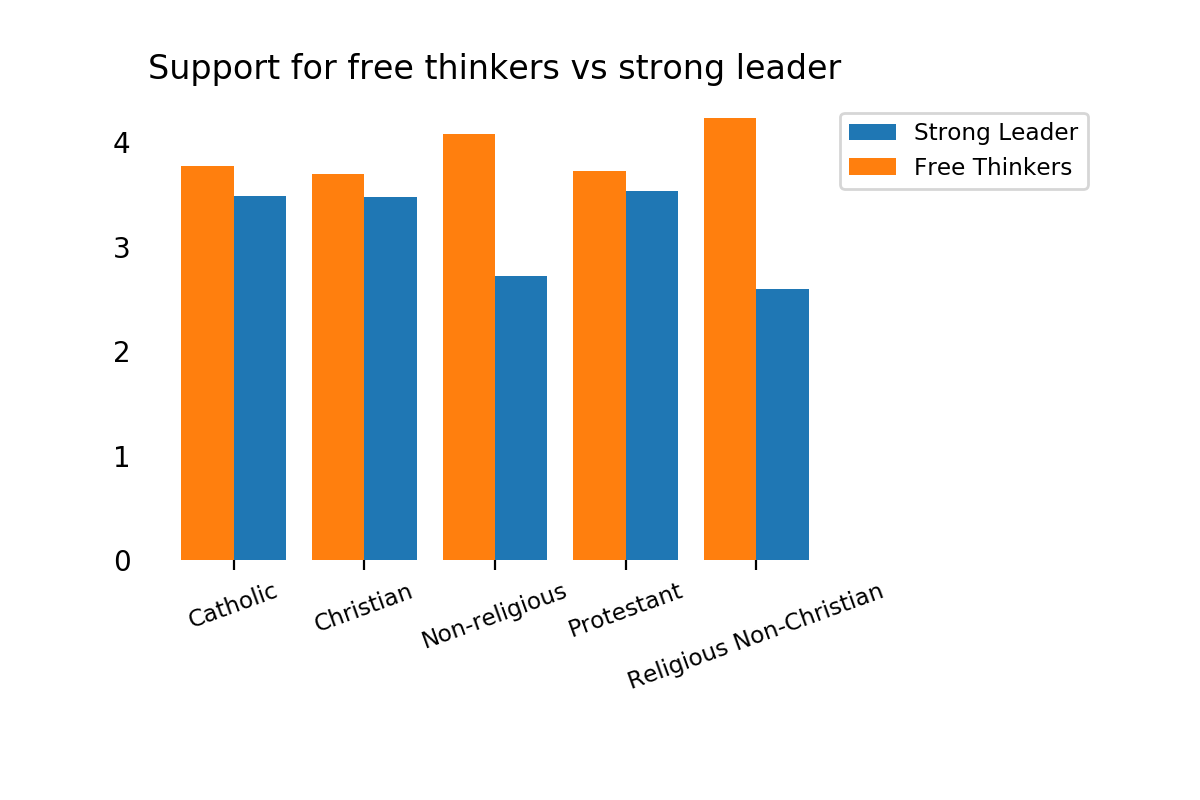

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
lbars = ax.bar(ftslmin.index, ftslmin['Strong Leader'].values, align='edge', width=.4)
tbars = ax.bar(ftslmin.index, ftslmin['Free Thinkers'].values, align='edge', width=-.4)

ax.set_frame_on(False)
ax.set_title('Support for free thinkers vs strong leader')
ax.legend((lbars, tbars), ('Strong Leader', 'Free Thinkers'), loc=(1,0.8), fontsize='small')

# ax.set_xmargin(100)
# ax.margins()
ax.tick_params(axis='x', labelrotation=20, labelsize='small')
ax.tick_params(left=False)

plt.subplots_adjust(bottom=0.3, right=0.7)
plt.savefig('preference_for_leaders.png')

In [23]:
combined = pd.DataFrame({'arda':ardadist, 'pew':pew}).dropna()
combined

,arda,pew
Catholic,0.227860,0.205184
Christian,0.020249,0.052579
Non-religious,0.179068,0.215449
Protestant,0.525738,0.451712
Religious Non-Christian,0.041230,0.048815


<IPython.core.display.Javascript object>


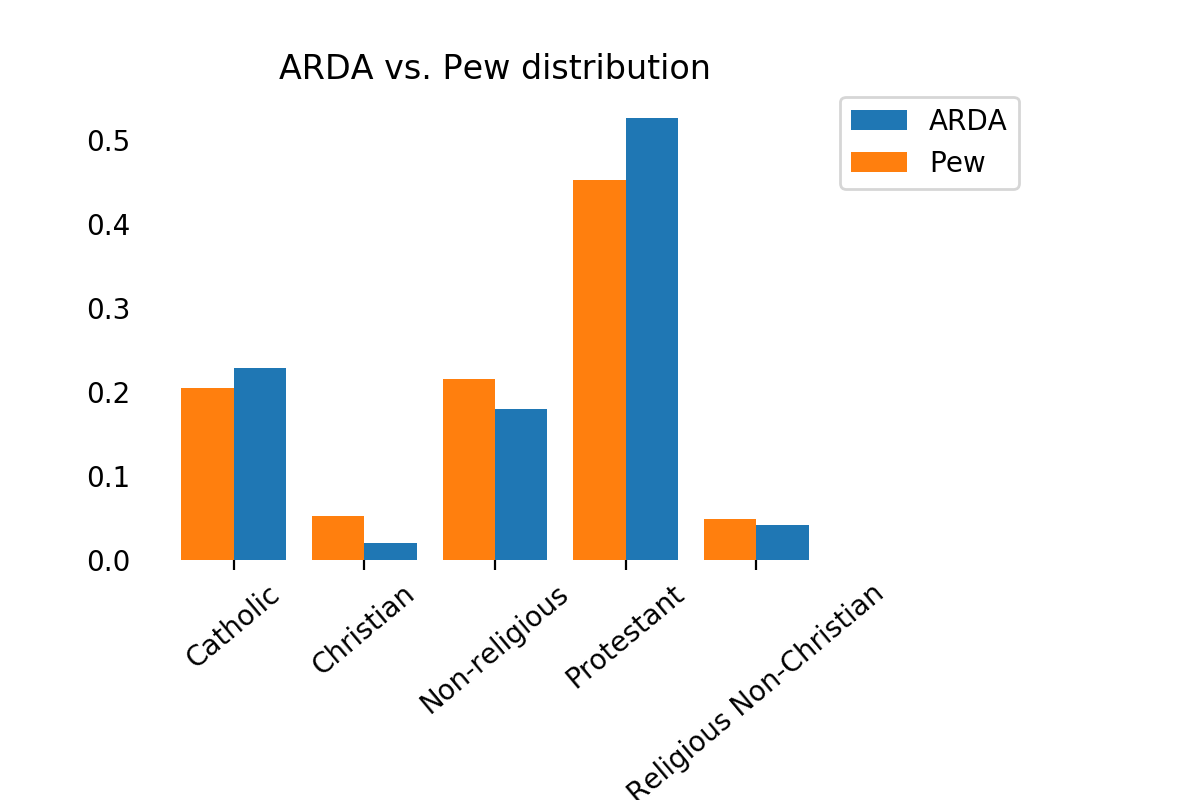

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))

lbars = ax.bar(ftslmin.index, combined['arda'].values, align='edge', width=.4)
tbars = ax.bar(ftslmin.index, combined['pew'].values, align='edge', width=-.4)

ax.set_frame_on(False)
ax.set_title('ARDA vs. Pew distribution')
ax.legend((lbars, tbars), ('ARDA', 'Pew'), loc=(1,0.8))

# ax.set_xmargin(100)
# ax.margins()
ax.tick_params(axis='x', labelrotation=40)
ax.tick_params(left=False)

plt.subplots_adjust(bottom=0.3, right=0.7)